#### Imports

In [1]:
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps
import seaborn as sns

from skimage import morphology
from skimage import io
from skimage.segmentation import slic, mark_boundaries

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import pickle 

#### Data

In [29]:
file_data = 'data/metadata.csv'
path_image =  'data/images/'
path_mask = 'data/masks/'
path_masked_image = 'data/masked_images'
file_features = 'features/features.csv'

images_id = os.listdir(path_image)
images_id.remove('.gitkeep')

#Read meta-data into a Pandas dataframe
metadata = pd.read_csv(file_data)


### Feature measurements functions

In [3]:
''' FUNCTION FOR APPLYING MASK TO AN IMAGE '''

def apply_mask(image, mask):
    '''Applies a mask to an image'''

    # Apply mask on the image
    masked_image = np.copy(image)
    masked_image[mask == 0] = 0
    return masked_image

In [4]:
''' ASYMMETRY ''' 

def fix_mask(mask):
    '''Turns a mask into only black(0) or white(255) pixel values. Put the leison in the
     center of the image '''

    #Make it purely black and white
    mask = mask.astype(int)
    mask_pic = Image.fromarray(np.uint8(mask * 255))
    
    #Crop the leison 
    row_index =  np.where(np.sum(mask, axis=1)>0)[0] #all the rows with at least one white element 
    first_row , last_row = row_index[0] , row_index[-1]  #first and last row 
    if (last_row - first_row) %2 != 0:
        last_row += 1 #one extra row to make it even and able to halve it

    col_index =  np.where(np.sum(mask, axis=0)>0)[0] #all the col with at least one white element 
    first_col , last_col = col_index[0] , col_index[-1]  #first and last col 
    if (last_col - first_col) %2 != 0:
        last_col += 1

    cropped_mask = mask_pic.crop((first_col,first_row,last_col,last_row))

    #Add borders
    old_width , old_height = cropped_mask.size 
    fixed_mask = ImageOps.expand(cropped_mask, border = int(old_width/2))

    return fixed_mask

def test_asymmetry(mask):
    '''Takes a mask image, halves it vertically, compares both sides. Returns an index of asymmetry 
    as the proportion of leisure that differs on both sides over the total leison'''

    width,height = mask.size

    #Cut in half
    left = mask.crop((0, 0, int(width/2), height)) #left part of picture (left, top, right, bottom)
    right = mask.crop((int(width/2), 0, width, height)) #right part of picture
    right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

    #Compairing both sides
    asym = np.sum(np.where(np.array(left) != np.array(right), 1, 0))
    total_white = np.sum(np.where(np.array(mask)==255, 1, 0))
   
    return round((asym/total_white), 3)


def get_asymmetry(mask):
    '''Returns the asymmetry for a given leison by rotating the mask image by several angles, measuring 
     the proportion of asymmetry on each, and returning the minimum index. '''
    
    #Leison in the center of the image. Expand black borders to give freedom when rotating image. 
    mask = fix_mask(mask)

    asym = [test_asymmetry(mask.rotate(angle)) for angle in [0,15,30,45,60,75,90]]

    return round(np.min(asym), 3)


In [5]:
def get_average_color(image, mask):
    # Apply mask to image
    masked_image = apply_mask(image, mask)

    r = masked_image[:, :, 0]
    g = masked_image[:, :, 1]
    b = masked_image[:, :, 2]
    
    return [(np.mean(r[r > 0])), (np.mean(g[g > 0])), (np.mean(b[b > 0]))]

In [6]:
def get_color_variability(image, mask, measure='variance'):
    
    # Apply mask on the image
    masked_image = apply_mask(image, mask)
 
    # Find the non-black pixels (i.e., the lesion pixels)
    non_black_pixels = np.where(np.any(masked_image > 0, axis=-1))

    # Extract the color values of the non-black pixels
    r = masked_image[non_black_pixels][:, 0]
    g = masked_image[non_black_pixels][:, 1]
    b = masked_image[non_black_pixels][:, 2]

    # Divide the lesion pixels into segments of similar color
    segments_slic = slic(masked_image[non_black_pixels], n_segments=10, compactness=1, sigma=3, start_label=1)

    # Compute the color variability for each segment that is within the lesion
    segment_color_variability_r = []
    segment_color_variability_g = []
    segment_color_variability_b = []
    for i in range(1, np.max(segments_slic) + 1):
        segment_pixels = np.where(segments_slic == i)[0]
        segment_r = r[segment_pixels]
        segment_g = g[segment_pixels]
        segment_b = b[segment_pixels]

        if measure == 'variance':
            rgb_variability = (np.var(segment_r), np.var(segment_g), np.var(segment_b))
        elif measure == 'standard_deviation':
            rgb_variability = (np.std(segment_r), np.std(segment_g), np.std(segment_b))
        else:
            return None

        segment_color_variability_r.append(rgb_variability[0])
        segment_color_variability_g.append(rgb_variability[1])
        segment_color_variability_b.append(rgb_variability[2])

    return [np.mean(segment_color_variability_r), np.mean(segment_color_variability_g), np.mean(segment_color_variability_b)]

In [7]:
'''COMPACTNESS'''

def area_perimeter(mask): 
    '''Measures the area and perimeter of a mask image'''

    mask = np.where(mask==1, 1, 0)

    #area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    #perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)

    return area, perimeter

 
def get_compactness(mask):
    '''Computes and returns the compactness of a figure'''

    area, perimeter = area_perimeter(mask)

    return round( (perimeter ** 2) /(4* np.pi *area), 4)


### Measuring features ---> csv

In [8]:
def extract_features(mask,image):
    '''Extracts the features of a given mask and image'''

    assymetry = get_asymmetry(mask)
    variability_r, variability_g, variability_b = get_color_variability(image,mask)
    compactness = get_compactness(mask)
    average_r, average_g, average_b = get_average_color(image,mask)

    return assymetry, variability_r, variability_g, variability_b, compactness, average_r, average_g, average_b

In [20]:
def extract_features(image,mask):
    '''Extracts the features of a given mask and image'''
    features = []

    features.append(get_asymmetry(mask))
    # features.append(get_color_variability(image,mask)) split into 3
    features.append((get_color_variability(image,mask)[0]))
    features.append((get_color_variability(image,mask)[1]))
    features.append((get_color_variability(image,mask)[2]))
    features.append(get_compactness(mask))
    # features.append(get_average_color(image,mask)) split into 3
    features.append((get_average_color(image,mask)[0]))
    features.append((get_average_color(image,mask)[1]))
    features.append((get_average_color(image,mask)[2]))

    return features

In [21]:
imy = plt.imread('PAT_875_1668_588.png')
masky = plt.imread('mask_PAT_875_1668_588.png')

In [22]:
print(extract_features(imy,masky))

C:\Users\raivi\AppData\Local\Temp\ipykernel_14144\3675960531.py:39: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare


[0.025, 0.0014466282, 0.0035304744, 0.005044098, 0.8495, 0.49774712, 0.30280036, 0.33815974]


In [45]:
# Create an empty DataFrame to store the extracted features
df = pd.DataFrame(columns=["Image_ID", "Asymmetry", "Color Variability (R)", "Color Variability (G)", "Color Variability (B)",
                           "Compactness", "Average Color (R)", "Average Color (G)", "Average Color (B)"])

# Iterate over the image files and extract the features
for image_id in images_id:
    # Construct the paths to the image and mask files
    image = plt.imread(path_image + image_id)
    mask = plt.imread(path_mask + 'mask_' + image_id)
    # image_path = os.path.join(image_folder, image_file)
    # mask_path = os.path.join(mask_folder, image_id + "_mask.png")  # Assuming the mask files follow a specific naming convention

    # Run the extract_features function to get the feature values
    features = extract_features(image, mask)
    
    # Create a dictionary with the feature values and image ID
    feature_dict = {"Image_ID": image_id}
    for i, feature_value in enumerate(features):
        feature_dict[df.columns[i + 1]] = feature_value
    
    # Append the feature values to the DataFrame
    df = df.append(feature_dict, ignore_index=True)


C:\Users\raivi\AppData\Local\Temp\ipykernel_14144\3675960531.py:39: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare


                 Image_ID  Asymmetry  Color Variability (R)  \
0     PAT_106_159_325.png      0.193               0.001147   
1     PAT_107_160_609.png      0.029               0.003076   
2     PAT_108_162_660.png      0.051               0.002316   
3    PAT_115_1138_870.png      0.192               0.006427   
4     PAT_117_179_983.png      0.225               0.003936   
..                    ...        ...                    ...   
145  PAT_966_1826_587.png      0.130               0.001211   
146  PAT_967_1827_247.png      0.065               0.003344   
147  PAT_975_4734_783.png      0.241               0.011523   
148    PAT_98_152_562.png      0.113               0.002221   
149    PAT_995_1867_5.png      0.215               0.006628   

     Color Variability (G)  Color Variability (B)  Compactness  \
0                 0.004648               0.004357       1.2113   
1                 0.008960               0.011092       0.8237   
2                 0.006765               0.00

In [46]:
# Add a column for the diagnosis called 'diagnostic' and take the values from the 'diagnostic' column in the metadata dataframe based on common values in left dataframe from column "image_id" and right dataframe "img_id"
df['Diagnostic'] = df['Image_ID'].map(metadata.set_index('img_id')['diagnostic'])

# Add a column called 'healthy' that is 1 if the diagnostic is in ["NEV", "SEK", "ACK"] and 0 if it is ["MEL", "SCC", "BCC"]
df['Healthy'] = df['Diagnostic'].isin(["NEV", "SEK", "ACK"]).astype(int)


In [47]:
# Save the features dataframe to csv file
df.to_csv('features1.csv', index=False)

### Train classifiers

In [12]:
'''Load and explore data'''
df.head()

,image_id,asymmetry,color_variability_r,color_variability_g,color_variability_b,compactness,diagnostic,healthy
0,PAT_106_159_325.png,0.193,354.682357,930.077322,793.910854,1.2113,BCC,0
1,PAT_107_160_609.png,0.029,217.405551,455.259902,372.242193,0.8237,SEK,1
2,PAT_108_162_660.png,0.051,319.108932,338.055330,385.779671,1.0391,ACK,1
3,PAT_115_1138_870.png,0.192,383.987975,485.455023,398.791744,1.3270,MEL,0
4,PAT_117_179_983.png,0.225,127.387285,267.219847,216.291752,1.6368,BCC,0


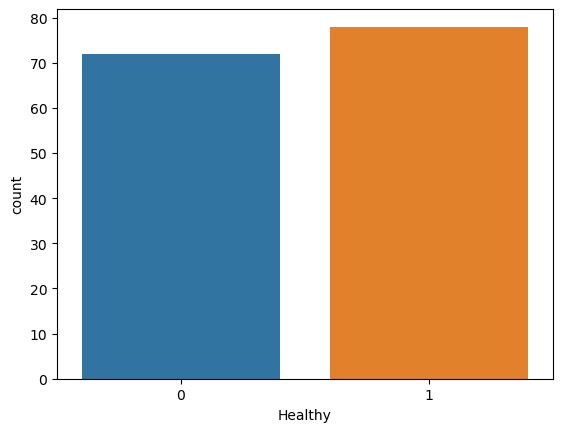

In [49]:
sns.countplot(data=df, x="Healthy");

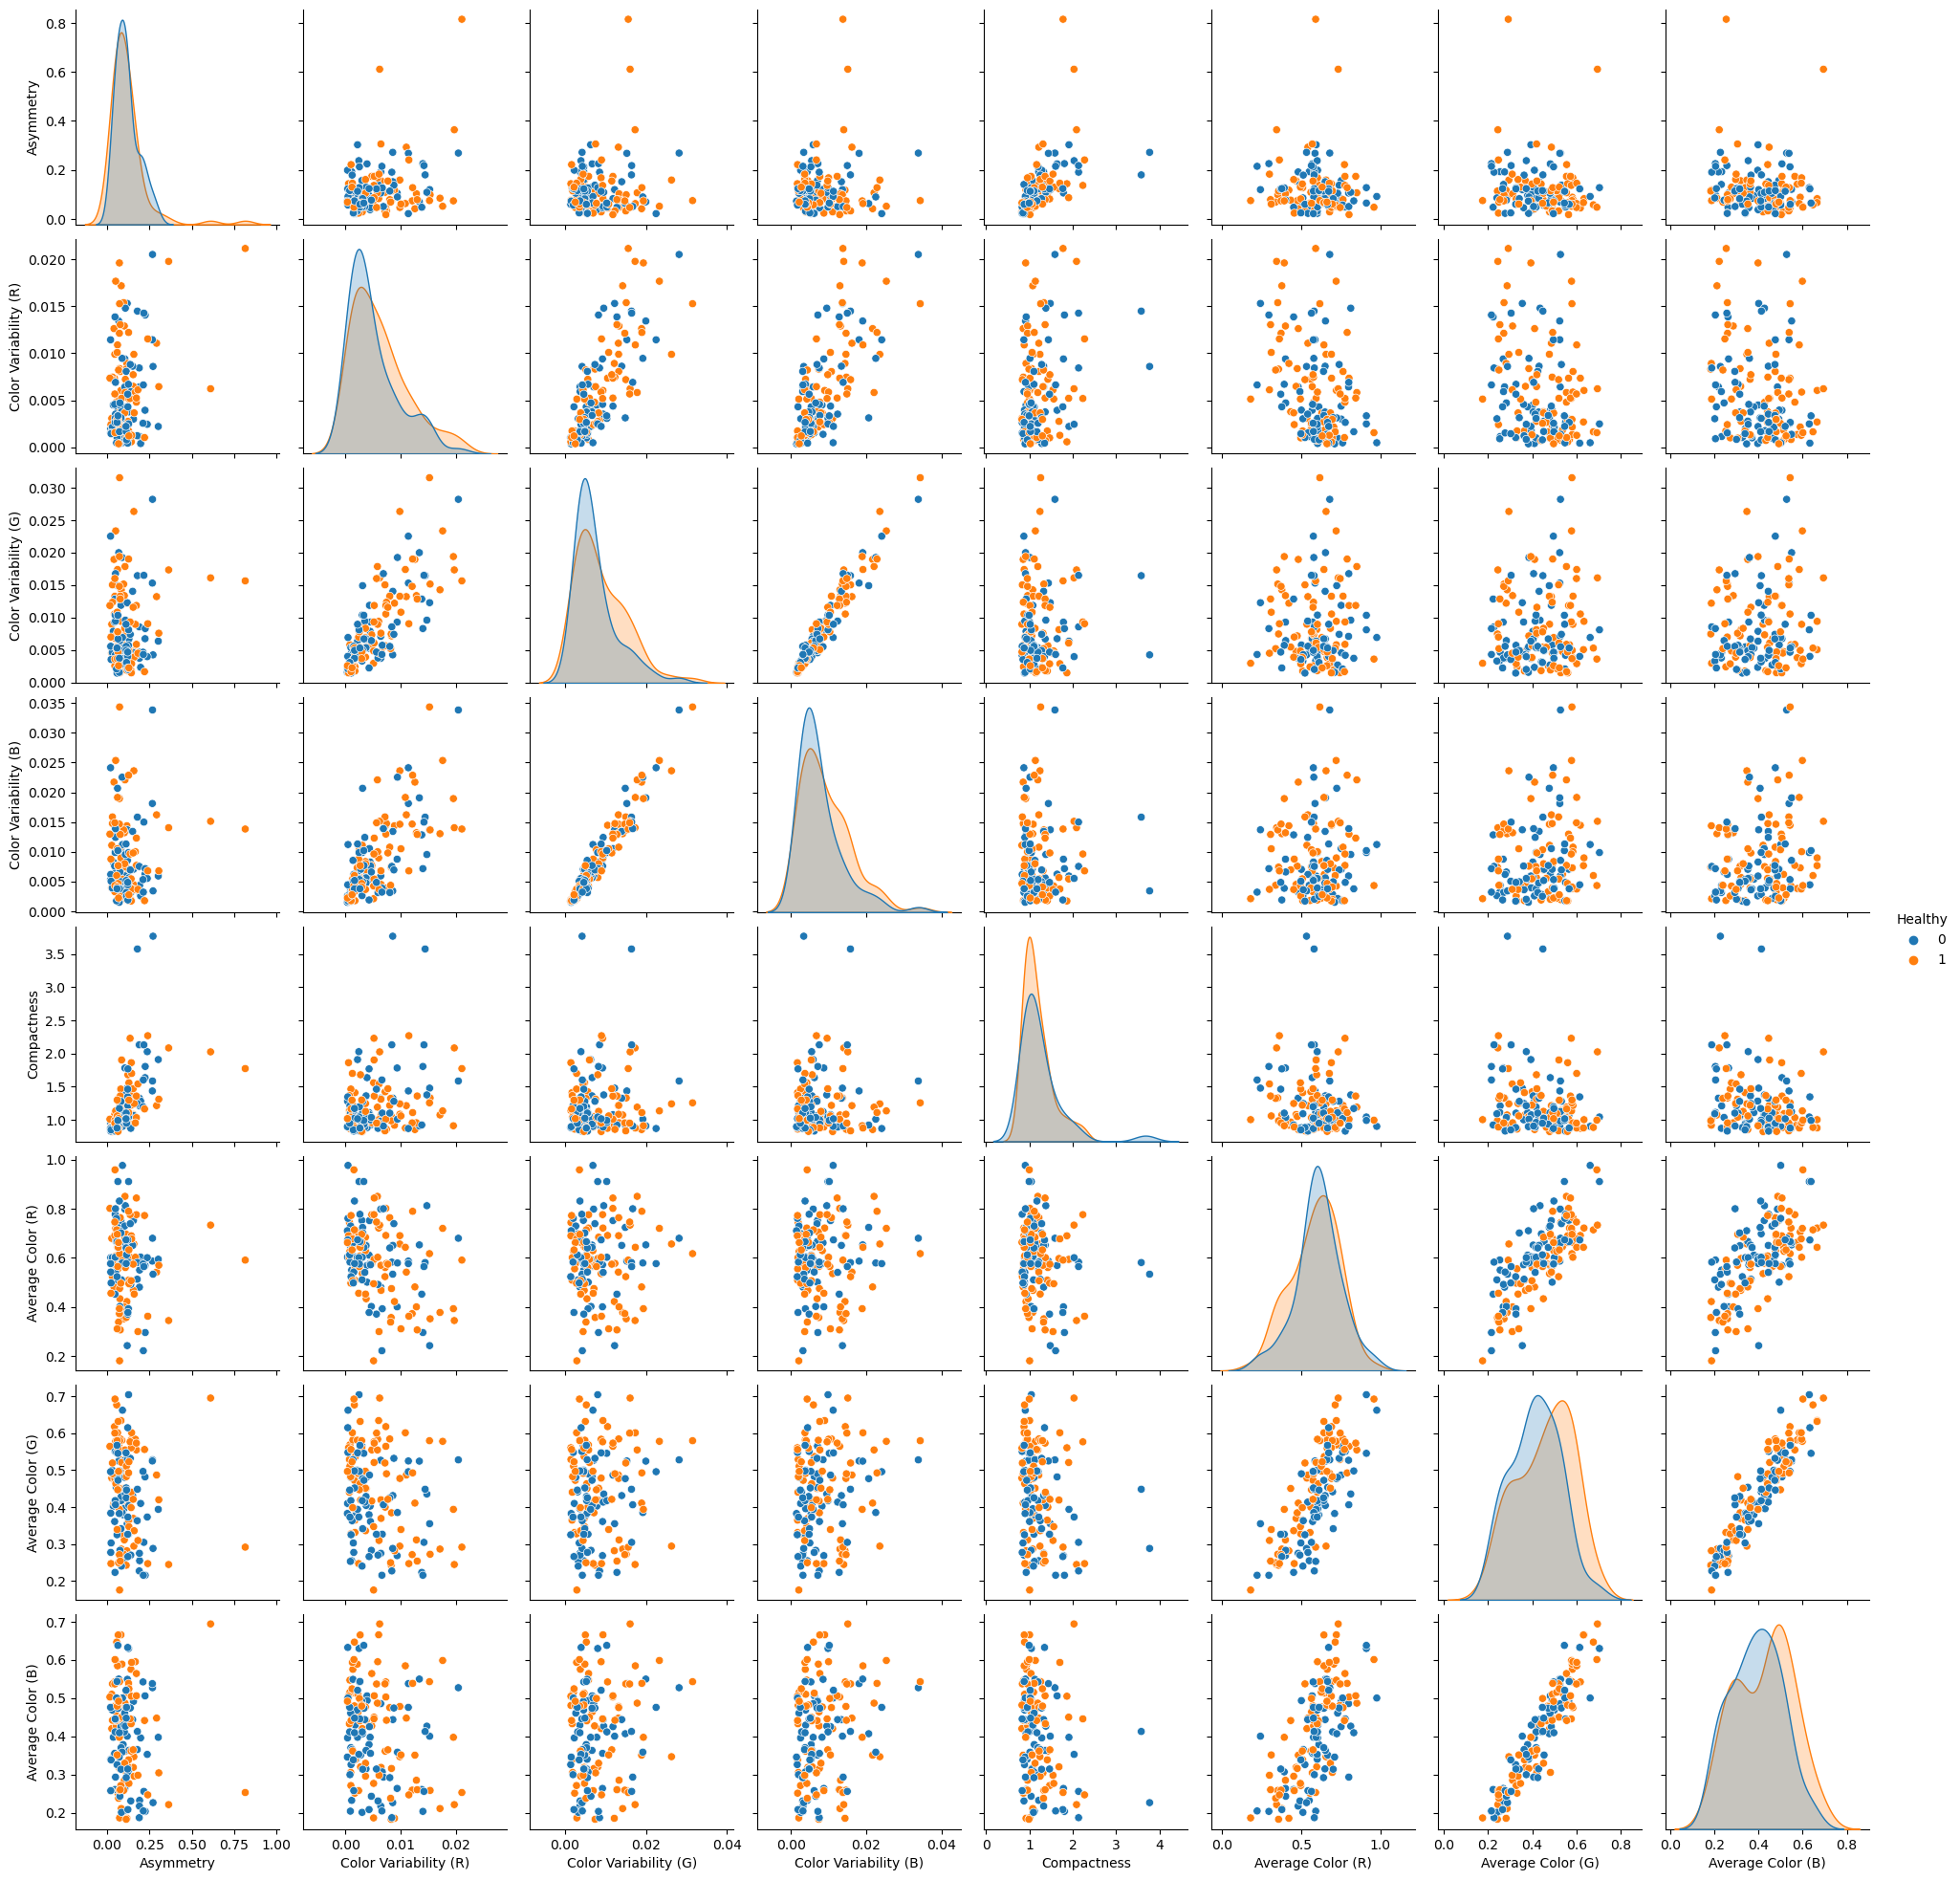

In [50]:
sns.pairplot(data=df, hue="Healthy");

In [55]:
df_clean = df.drop(["Image_ID", "Diagnostic"], axis=1)
df_clean

,Asymmetry,Color Variability (R),Color Variability (G),Color Variability (B),Compactness,Average Color (R),Average Color (G),Average Color (B),Healthy
0,0.193,0.001147,0.004648,0.004357,1.2113,0.550330,0.254795,0.232036,0
1,0.029,0.003076,0.008960,0.011092,0.8237,0.535625,0.478589,0.420036,1
2,0.051,0.002316,0.006765,0.007490,1.0391,0.565348,0.489717,0.463897,1
3,0.192,0.006427,0.003720,0.003231,1.3270,0.480543,0.274811,0.217110,0
4,0.225,0.003936,0.006734,0.006242,1.6368,0.569064,0.481785,0.505810,0
...,...,...,...,...,...,...,...,...,...
145,0.130,0.001211,0.002247,0.002772,1.2976,0.632436,0.522676,0.524337,1
146,0.065,0.003344,0.010338,0.010198,0.9914,0.911278,0.545584,0.637944,0
147,0.241,0.011523,0.009041,0.006787,2.2698,0.362007,0.246900,0.246481,1
148,0.113,0.002221,0.008954,0.011307,1.0163,0.673452,0.546913,0.520429,0


### Train, dev, test split

In [56]:
# Get the features labels into separate vars
X, y = df_clean.iloc[:, :-1], df_clean.iloc[:, -1]

# Train, dev (hyper-parameter tuning), test (use to evaluate your final model and include the stats to report) split
# -- Train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# -- Split the training dataset into train and dev
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Train the models

In [57]:
# Hyper-parameters
lr = LogisticRegression(random_state=42)
knn_2= KNeighborsClassifier(n_neighbors=1)
knn_5 = KNeighborsClassifier(n_neighbors=5)
models = [("lr", lr), ("knn 2 neighbors", knn_2), ("knn 5 neighbors", knn_5)]

# Training
for _, clf in models:
    clf.fit(X_train, y_train);

### Evaluate

In [58]:
''' On training'''
metrics = [("f1", f1_score), ("acc", accuracy_score)]

for m_name, clf in models:
    print(f"Model: {m_name}")
    print("-"*50)
    for me_name, metricf in metrics:
        y_pred = clf.predict(X_train)
        s = metricf(y_train, y_pred)
        print(f"{me_name}: {s}")
    print()

Model: lr
--------------------------------------------------
f1: 0.6875000000000001
acc: 0.6153846153846154

Model: knn 2 neighbors
--------------------------------------------------
f1: 1.0
acc: 1.0

Model: knn 5 neighbors
--------------------------------------------------
f1: 0.6913580246913581
acc: 0.6794871794871795



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [59]:
''' On dev dataset'''

metrics = [("f1", f1_score), ("acc", accuracy_score)]

for m_name, clf in models:
    print(f"Model: {m_name}")
    print("-"*50)
    for me_name, metricf in metrics:
        y_pred = clf.predict(X_dev)
        s = metricf(y_dev, y_pred)
        print(f"{me_name}: {s}")
    print()

Model: lr
--------------------------------------------------
f1: 0.5714285714285714
acc: 0.5555555555555556

Model: knn 2 neighbors
--------------------------------------------------
f1: 0.34782608695652173
acc: 0.4444444444444444

Model: knn 5 neighbors
--------------------------------------------------
f1: 0.5
acc: 0.48148148148148145



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

### Evaluate on test

In [60]:
metrics = [("f1", f1_score), ("acc", accuracy_score)]
models_for_test_eval = []

for m_name, clf in models:
    print(f"Model: {m_name}")
    print("-"*50)
    for me_name, metricf in metrics:
        y_pred = clf.predict(X_dev)
        s = metricf(y_dev, y_pred)
        print(f"{me_name}: {s}")
    print()

Model: lr
--------------------------------------------------
f1: 0.5714285714285714
acc: 0.5555555555555556

Model: knn 2 neighbors
--------------------------------------------------
f1: 0.34782608695652173
acc: 0.4444444444444444

Model: knn 5 neighbors
--------------------------------------------------
f1: 0.5
acc: 0.48148148148148145



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [41]:
'''Choose our best classifier and save it'''

classifier = KNeighborsClassifier(n_neighbors = 2)

classifier = classifier.fit(X,y)

filename = 'group8_classifier.sav'
pickle.dump(classifier, open(filename, 'wb'))

### Evaluate classifier

In [ ]:
def classify(img, mask):

     img = 
    
     X = []
     

     
    
     #Extract features
     x = extract_features(img, mask)
         
     
     #Load the trained classifier
     classifier = pickle.load(open('group8_classifier.sav', 'rb'))
    
    
     #Use it on this example to predict the label AND posterior probability
     pred_label = classifier.predict(X)
     pred_prob = classifier.predict_proba(X)
     
     print('predicted label is ', pred_label)
     print('predicted probability is ', pred_prob)

     return pred_label, pred_prob
 
